In [41]:
import h5py 
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from prophet.plot import plot_plotly,plot_components_plotly
from prophet import Prophet

In [42]:
given_lat= -20.296059
given_lon= -85.824539

In [43]:
date_column = np.empty((0,),dtype='datetime64')
conc_column = np.empty((0,),dtype='float32')

In [44]:
lon_index = int(((np.floor(given_lon/0.25) * 0.25) - (-180))/0.25)
lon_index = 0 if lon_index == 1440 else lon_index
lat_index = int(((np.floor(given_lat/0.25) * 0.25) - (-90))/0.25)
lat_index = 0 if lat_index == 720 else lat_index

In [45]:
# keep data files here
data_folder = os.listdir('../data/no2-data') 

In [46]:
for data_file in data_folder:
    data = h5py.File(f"../data/no2-data/{data_file}",'r')
    
    dataset = data.require_dataset('/HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2',shape=(720,1440),dtype='float32')
    conc_data = np.array(dataset)
    conc_val = conc_data[lat_index][lon_index]

    attributes = data.require_group('/HDFEOS/ADDITIONAL/FILE_ATTRIBUTES')
    date_str = attributes.attrs.get('EndUTC').decode('utf-8')
    date_val = np.datetime64(date_str)
    date_val

    date_column = np.append(date_column, date_val)
    conc_column = np.append(conc_column,conc_val)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12676\1806063583.py:10: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_val = np.datetime64(date_str)


In [47]:
date_column.shape

(1094,)

In [48]:
conc_column.shape

(1094,)

In [49]:
no2_df = pd.DataFrame({'conc' : conc_column}, index=date_column)
no2_df.index = pd.to_datetime(no2_df.index.strftime('%Y-%m-%d'),format='%Y-%m-%d')
no2_df

,conc
2021-04-02,2.108130e+15
2021-04-03,-1.267651e+30
2021-04-04,2.590950e+15
2021-04-05,6.300532e+14
2021-04-06,1.983300e+15
...,...
2024-03-28,2.029209e+15
2024-03-29,-1.267651e+30
2024-03-30,2.532583e+15
2024-03-31,2.076821e+15


In [50]:
no2_df.describe()

C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,conc
count,1.094000e+03
mean,-2.723015e+29
std,inf
min,-1.267651e+30
25%,1.473712e+15
50%,2.282262e+15
75%,2.679858e+15
max,3.960419e+15


In [51]:
no2_df[no2_df['conc']<0].value_counts()

conc         
-1.267651e+30    235
-1.005388e+15      1
-3.127651e+14      1
-2.020557e+14      1
-7.231659e+13      1
-4.566549e+13      1
Name: count, dtype: int64

In [52]:
filtered_no2_df= no2_df[no2_df['conc']>=0]
filtered_no2_df.conc.mean()

2434618000000000.0

In [53]:
no2_df.loc[no2_df['conc']<0,'conc'] =  filtered_no2_df.conc.mean()
no2_df

,conc
2021-04-02,2.108130e+15
2021-04-03,2.434618e+15
2021-04-04,2.590950e+15
2021-04-05,6.300532e+14
2021-04-06,1.983300e+15
...,...
2024-03-28,2.029209e+15
2024-03-29,2.434618e+15
2024-03-30,2.532583e+15
2024-03-31,2.076821e+15


In [54]:
scaler = MinMaxScaler()
no2_df['conc'] = scaler.fit_transform(no2_df[['conc']])
no2_df

,conc
2021-04-02,0.508746
2021-04-03,0.595335
2021-04-04,0.636797
2021-04-05,0.116738
2021-04-06,0.475639
...,...
2024-03-28,0.487815
2024-03-29,0.595335
2024-03-30,0.621317
2024-03-31,0.500442


In [55]:
no2_df['datetime'] = no2_df.index.astype('str')
no2_df = no2_df[['datetime','conc']]
no2_df.reset_index(drop=True, inplace=True)
no2_df.columns=['ds','y']
no2_df

,ds,y
0,2021-04-02,0.508746
1,2021-04-03,0.595335
2,2021-04-04,0.636797
3,2021-04-05,0.116738
4,2021-04-06,0.475639
...,...,...
1089,2024-03-28,0.487815
1090,2024-03-29,0.595335
1091,2024-03-30,0.621317
1092,2024-03-31,0.500442


In [56]:
no2_df.to_csv('../data/no2.csv', index=False)

In [57]:
pro_model = Prophet(interval_width=0.95)

In [58]:
pro_model.fit(no2_df)

19:37:41 - cmdstanpy - INFO - Chain [1] start processing
19:37:41 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
future_date = pro_model.make_future_dataframe(periods=60, freq='MS')
future_date.tail()

,ds
1149,2028-12-01
1150,2029-01-01
1151,2029-02-01
1152,2029-03-01
1153,2029-04-01


In [60]:
forecast = pro_model.predict(future_date)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-04-02,0.523314,0.299611,0.766937
1,2021-04-03,0.555175,0.347969,0.770206
2,2021-04-04,0.537319,0.317744,0.755298
3,2021-04-05,0.541751,0.332086,0.750330
4,2021-04-06,0.528946,0.321556,0.735610


C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


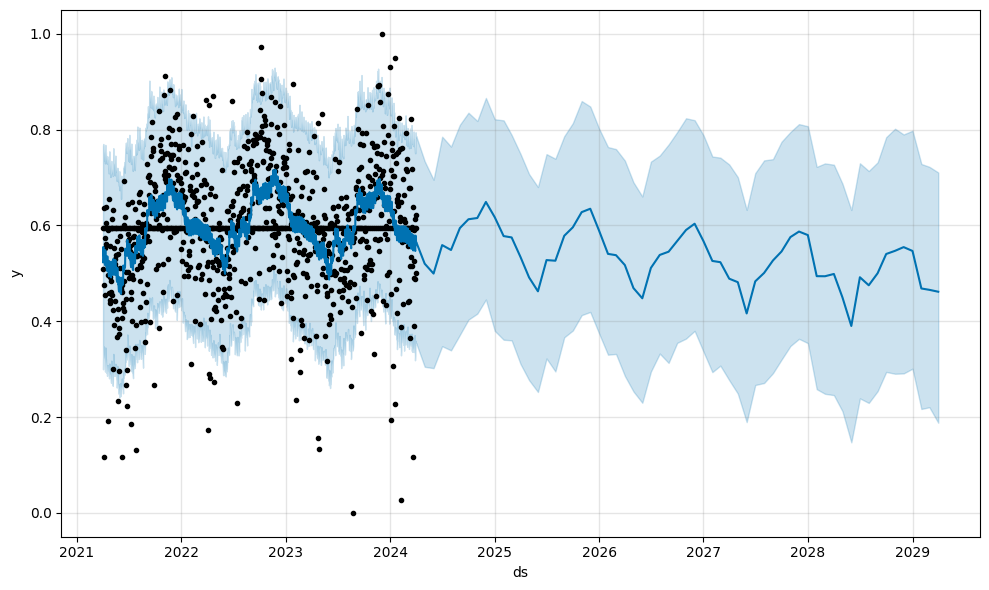

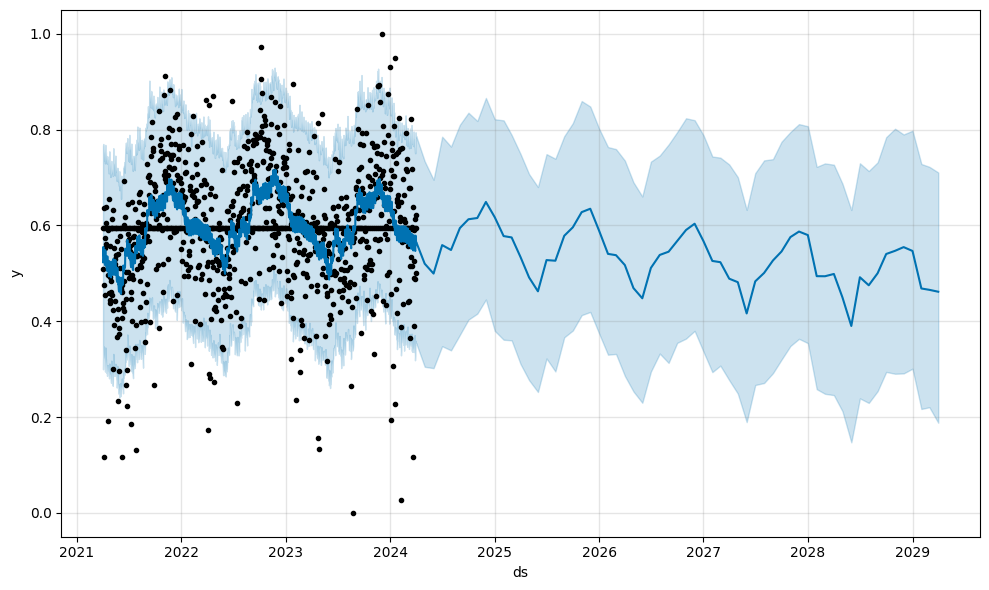

In [61]:
pro_model.plot(forecast, uncertainty=True)

C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is

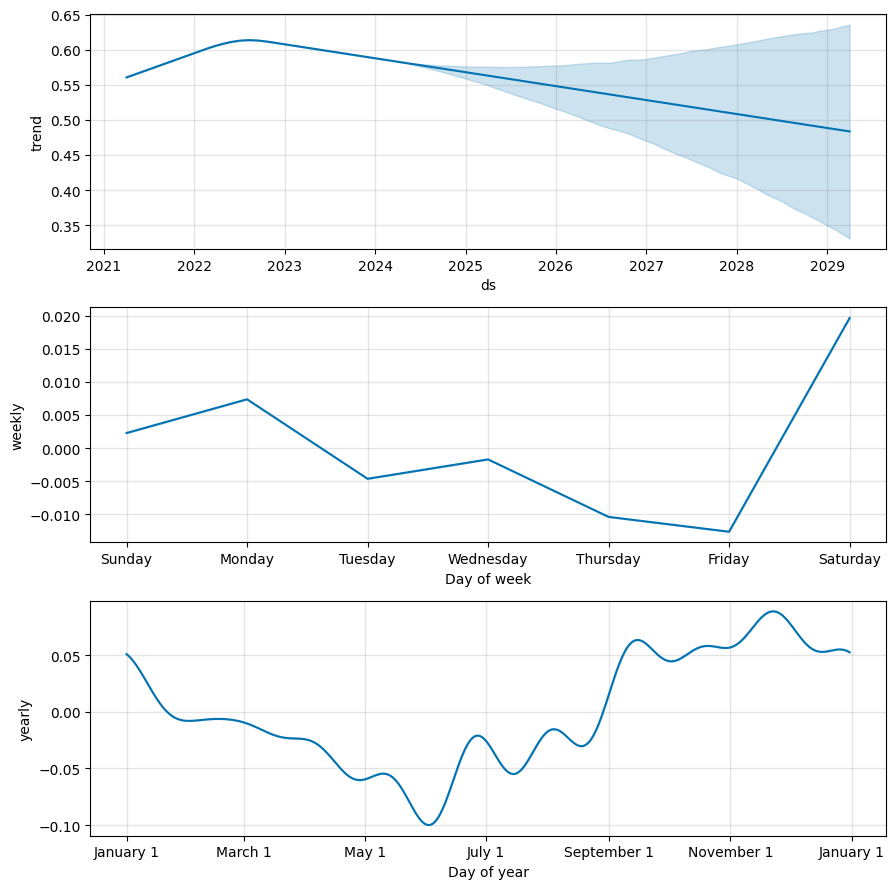

In [62]:
fig1=pro_model.plot_components(forecast)

C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


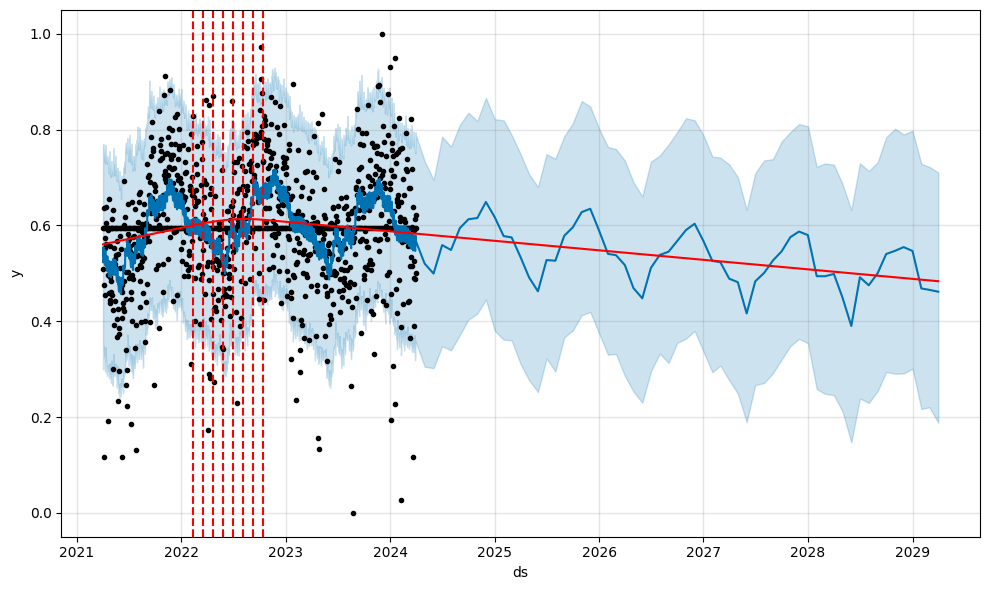

In [63]:
from prophet.plot import add_changepoints_to_plot
fig =pro_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),pro_model,forecast)

In [64]:
pro_model.changepoints

35    2021-05-07
70    2021-06-11
105   2021-07-16
140   2021-08-20
175   2021-09-24
210   2021-10-29
245   2021-12-03
280   2022-01-07
315   2022-02-11
350   2022-03-18
385   2022-04-22
420   2022-05-27
454   2022-06-30
489   2022-08-04
524   2022-09-08
559   2022-10-13
594   2022-11-17
629   2022-12-22
664   2023-01-26
699   2023-03-02
734   2023-04-06
769   2023-05-11
804   2023-06-15
839   2023-07-20
874   2023-08-24
Name: ds, dtype: datetime64[ns]

19:37:46 - cmdstanpy - INFO - Chain [1] start processing
19:37:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


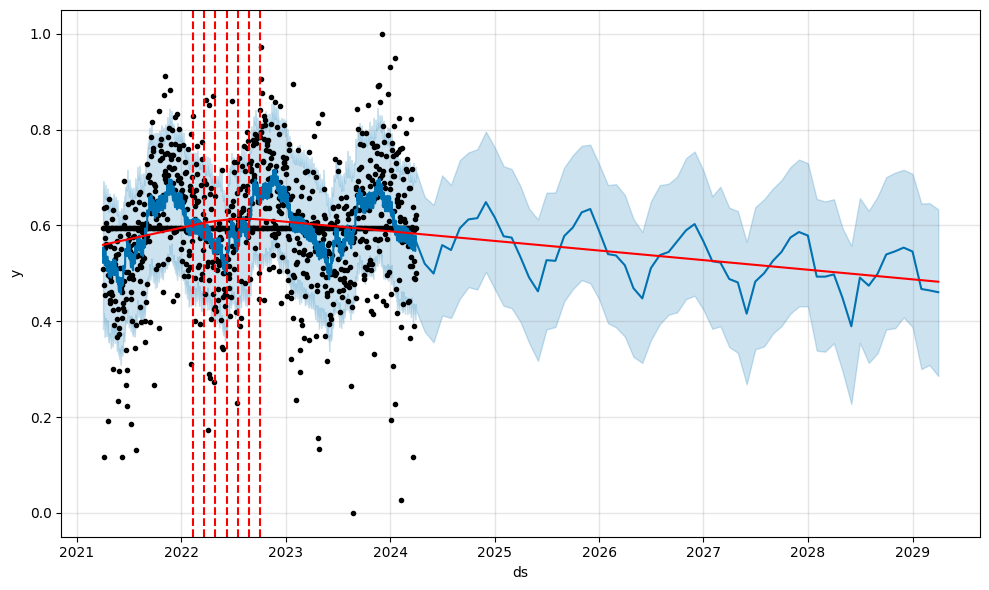

In [65]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(no2_df).predict(future_date)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)